In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
data_set=pd.read_csv(r'diabetes.csv')
train_set=data_set[0:600]
test_set=data_set[600:769]
train_set=np.array(train_set)
test_set=np.array(test_set)

x_train=train_set[:,:8]
y_train=train_set[:,8]
y_train=y_train.reshape((1,600))

x_test=test_set[:,:8]
y_test=test_set[:,8]
y_test=y_test.reshape((1,168))

x_train=x_train.T
x_test=x_test.T

def z_normalization(X):
    m = np.mean(X, axis=1, keepdims=True)
    sig = np.std(X, axis=1, keepdims=True)
    normalized_x = (X - m) / sig
    return normalized_x
x_train=z_normalization(x_train)
x_test=z_normalization(x_test)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8, 600)
(8, 168)
(1, 600)
(1, 168)


In [223]:
def predict(x,w,b):
    z=np.dot(w,x)+b
    return z
def init_params(n,m):
    w1=np.random.randn(15,n)*np.sqrt(2/(n))
    w2=np.random.randn(6,15)*np.sqrt(2/(15))
    w3=np.random.randn(1,6)*np.sqrt(2/(6))
    b1=np.zeros((15,1))
    b2=np.zeros((6,1))
    b3=np.zeros((1,1))
    return w1,w2,w3,b1,b2,b3

In [224]:
def sigmoid(z):
    A=1/(1+np.exp(-z))
    return A
def derivative_sigmoid(A):
    dA=A*(1-A)
    return dA
def derivative_tanh(A):
    return 1-(np.tanh(A))**2

In [225]:
def forward_propagation(x,w1,w2,w3,b1,b2,b3):
    z1=predict(x,w1,b1)
    a1=sigmoid(z1)
    # a1=np.tanh(z1)
    z2=predict(a1,w2,b2)
    a2=sigmoid(z2)
    # a2=np.tanh(z2)
    z3=predict(a2,w3,b3)
    a3=sigmoid(z3)
    return z1,a1,z2,a2,z3,a3

In [226]:
def backward_propagation(x,y,a1,a2,a3,z1,z2,z3,w1,w2,w3):
    m=y.shape[1]
    # total_cost=total_loss
    # loss_each=-y*log(a3)-(1-y)*log(1-a3)
    # dloss/da3=(-y/a3)+(1-y/1-a3)
    # da3=(-y/a3)+(1-y/1-a3)
    # dloss/dz3=[dloss/da3]*[da3/dz3]
    #           =(-y/a3)+(1-y/1-a3) * derivation of sigmoid(z3)
    #           =(-y/a3)+(1-y/1-a3) * a3*(1-a3)
    #       dz3 =[a3-y]
    dz3=(a3-y)
    # dw3= dz3* [dz3/dw3]
    #     = (a3-y) * d(np.dot(a2,w3)+b)/d(w3)
    #     = (a3-y) * a2
    #     check the dimentions matching or not
    #     dw3= (a3-y)* a2
    dw3=(1./m)*np.dot(dz3,(a2.T))
    db3=(1./m)*np.sum(dz3,axis=1,keepdims=True)

    
    # da2= dz3* [dz3/da2]
    #     = dz3 * d(np.dot(a2,w3)+b)/d(a2)
    #     = dz3 * w3
    #     check the dimentions matching
    # da2= dz3*(w3)
    da2=np.dot(w3.T,dz3)
    # dz2= da2* (da2/dz2)
    #     here a2=np.tanh(z2)
    #     so da2/dz2=derivative_tanh(z2)
    #     dz2= da2 * (1-(a2))**2
    #     check dimentionality
    dz2= da2*derivative_sigmoid(z2)
    # by observing above pattern we can compute that dwi=dzi*a(i-1)
    dw2= (1./m)*np.dot(dz2,a1.T)
    db2=(1./m)*np.sum(dz2,axis=1,keepdims=True)

    # da1=dz2* [dz2/da1]
    #     =dz2* np.dot(a1,w2)+b2/d(a1)
    #     =dz2 * [w2]
    #     check dimentionality
    da1=np.dot(w2.T,dz2)
    # dz1= da1* da1/dz1
    #     = da1 * d(np.tanh(z1))/d(z1)
    #     = da1 * (1-np.tanh(z1))**2
    #     = da1 * (1-a1)**2
    #     check dimentionality and build equation 
    dz1= da1* derivative_sigmoid(z1)
    # dw1= dz1* (a0==x)
    dw1=(1./m)*np.dot(dz1,x.T)
    db1= (1./m)*np.sum(dz1,axis=1,keepdims=True)

    return dw1,db1,dw2,db2,dw3,db3
    
    

In [227]:
def update_params(w1,w2,w3,b1,b2,b3,dw1,dw2,dw3,db1,db2,db3,alpha):
    w1=w1-(alpha*dw1)
    w2=w2-(alpha*dw2)
    w3=w3-(alpha*dw3)
    b1=b1-(alpha*db1)
    b2=b2-(alpha*db2)
    b3=b3-(alpha*db3)
    return w1,b1,w2,b2,w3,b3
    

In [228]:
def compute_cost(a3,y):
    m=y.shape[1]
    cost=(1./m)*(np.sum(-y*np.log(a3)-(1-y)*np.log(1-a3),axis=1))
    return cost

In [229]:
def actual_predict(a3):
    return (a3>=0.5).astype(int)
def accuracy(y,a3):
    y_hat=actual_predict(a3)
    return np.mean(y==y_hat)

In [230]:
def model(x,y,alpha,iterations):
    m=x.shape[1]
    n=x.shape[0]
    j_cost=[]
    j_iter=[]
    w1,w2,w3,b1,b2,b3=init_params(n,m)
    for i in range(iterations):
        z1,a1,z2,a2,z3,a3=forward_propagation(x,w1,w2,w3,b1,b2,b3)
        dw1,db1,dw2,db2,dw3,db3=backward_propagation(x,y,a1,a2,a3,z1,z2,z3,w1,w2,w3)
        w1,b1,w2,b2,w3,b3=update_params(w1,w2,w3,b1,b2,b3,dw1,dw2,dw3,db1,db2,db3,alpha)
        if i%1000==0 or i==iterations-1:
            temp_cost=compute_cost(a3,y)
            # print(f"cost: {temp_cost}")
            # print(f"Accuracy: {accuracy(y,a3)}")
            j_cost.append(temp_cost)
            j_iter.append(i)
    return w1,b1,w2,b2,w3,b3,j_cost,j_iter

            
            

C:\Users\ramis\AppData\Local\Temp\ipykernel_15820\2945687443.py:2: RuntimeWarning: overflow encountered in exp
  A=1/(1+np.exp(-z))
C:\Users\ramis\AppData\Local\Temp\ipykernel_15820\2945687443.py:5: RuntimeWarning: overflow encountered in multiply
  dA=A*(1-A)


Accuracy for Train Data:0.6533333333333333
Accuracy for Test Data:0.6428571428571429


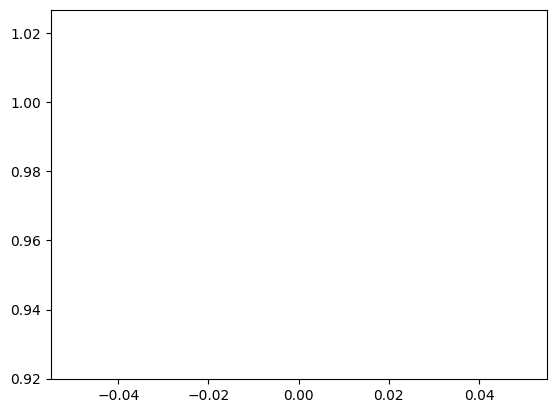

In [233]:
itera=10000
alpha=0.02
w1,b1,w2,b2,w3,b3,j_cost,j_iter=model(x_train,y_train,alpha,itera)
z1,a1,z2,a2,z3,a3_test=forward_propagation(x_test,w1,w2,w3,b1,b2,b3)
z1,a1,z2,a2,z3,a3_train=forward_propagation(x_train,w1,w2,w3,b1,b2,b3)
print(f"Accuracy for Train Data:{accuracy(y_train,a3_train)}")
print(f"Accuracy for Test Data:{accuracy(y_test,a3_test)}")
plt.plot(j_iter,j_cost)